In [27]:
from __future__ import print_function
from torchvision import transforms
from torchvision import models
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def load_image(image_path,transform=None,max_size=None,shape=None):
    image=Image.open(image_path)
    
    if max_size:
        scale=max_size/max(image.size)
        size=np.array(image.size)*scale
        image=image.resize(size.astype(int),Image.ANTIALIAS)
        
    if shape:
        image=image.resize(shape,Image.ANTIALIAS)
        
    if transform:
        image=transform(image).unsqueeze(0)
        
    return image

In [5]:
class VGGNet(nn.Module):
    def __init__(self,type=1):
        super().__init__()
        self.vgg=models.vgg19(pretrained=True).features
        if (type=="content") or (type==0):
            self.select=["19"]
        else:
            self.select=["0","5","10","19","28"]
    
    def forward(self,x):
        features=[]
        for name,layer in self.vgg._modules.items():
            x=layer(x)
            if name in self.select:
                features.append(x)
        return features
    

In [25]:
def main():
    mean=(0.485,0.456,0.406)
    std=(0.229,0.224,0.225)
    transform=transforms.Compose([transforms.ToTensor()
                                 ,transforms.Normalize(mean=mean,std=std)])
    content=load_image(r"G:\深度学习代码\torch实现神经网络风格迁移\dancing.jpg",transform,max_size=400)  
    #iamge.convert("RGB")可将png的RGBA模式转换为jog的RGB模式
    style=load_image(r"G:\深度学习代码\torch实现神经网络风格迁移\picasso.jpg",transform,shape=[content.size(2),content.size(3)])
    target=content.clone().requires_grad_(True)
    loss_func=nn.MSELoss()
    optim=torch.optim.SGD([target],lr=0.01)
    vgg_content=VGGNet("content").eval()
    vgg_style=VGGNet().eval()
    for step in range(200):
        target_features=vgg_content(target)+vgg_style(target)
        content_features=vgg_content(content)
        style_features=vgg_style(style)
        content_loss=loss_func(vgg_content(target)[0],vgg_content(content)[0])
        style_loss=0
        for f1,f2 in zip(vgg_style(target),vgg_style(style)):
            n,c,h,w=f1.size()
            f1=f1.view(c,h*w)
            f2=f2.view(c,h*w)
            f1_gram_mat=torch.mm(f1,f1.t())
            f2_gram_mat=torch.mm(f2,f2.t())
            style_loss+=loss_func(f1_gram_mat,f2_gram_mat)/(c*h*w)
        loss=content_loss+100*style_loss
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if (step+1)%50==0:
            print("step:[{}/{}],content_loss:{:.4f},style_loss:{:.4f}".format(step+1,2000,content_loss.item(),style_loss.item()))
            img=target.squeeze().detach()
            img=np.stack([img[i]*std[i]+mean[i] for i in range(3)],axis=-1)
            img=img.clip(0,1)
            plt.imshow(img)
            plt.show()
            

step:[50/2000],content_loss:25.7186,style_loss:348.4734


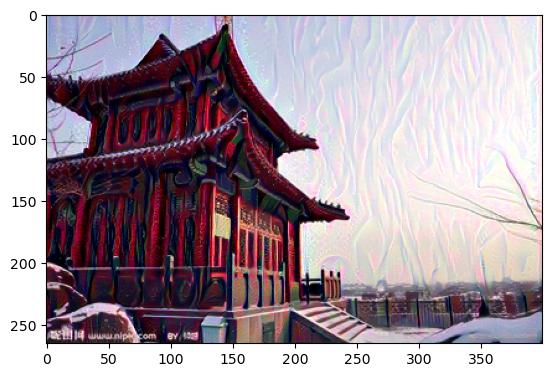

In [ ]:
main()

In [14]:
image=Image.open(r"G:\深度学习代码\torch实现神经网络风格迁移\dancing.jpg")
np.array(image.size)*4/5

array([819.2, 544. ])

In [142]:
a=torch.randn([4,3,5,5])
b=torch.ones([4,3,5,5])
loss_func=nn.MSELoss()
for f1,f2 in zip(a,b):
    c,h,w = f1.size()
    f1_mat=f1.view(c,h*w)
    f2_mat=f2.view(c,h*w)
    loss_f=loss_func(f1_mat,f2_mat)
    loss_t=torch.mean((f1-f2)**2)
    print("loss_f",loss_f)
    print("loss_t",loss_t)

loss_f tensor(1.9264)
loss_t tensor(1.9264)
loss_f tensor(2.1152)
loss_t tensor(2.1152)
loss_f tensor(2.1861)
loss_t tensor(2.1861)
loss_f tensor(2.1416)
loss_t tensor(2.1416)


In [64]:
transform=transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize(mean=(0.485,0.456,0.406)
                         ,std=(0.229,0.224,0.225))
    ,transforms.Resize([400,400])
])
image=Image.open(r"G:\深度学习代码\torch实现神经网络风格迁移\dancing.jpg")
print(image.size)
img=transform(image)
print(img.shape)

(1024, 680)
torch.Size([3, 400, 400])


step [50/2000] , content_loss:41.0350,Style_loss:492.3904


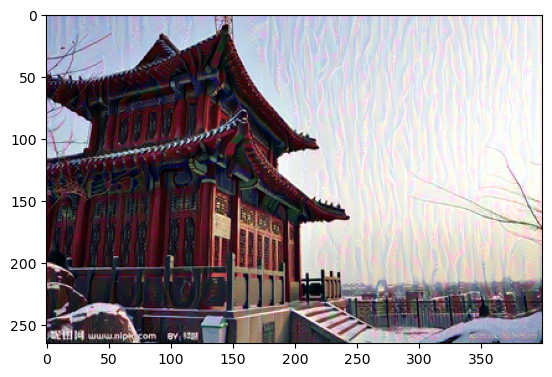

step [100/2000] , content_loss:51.6076,Style_loss:299.4420


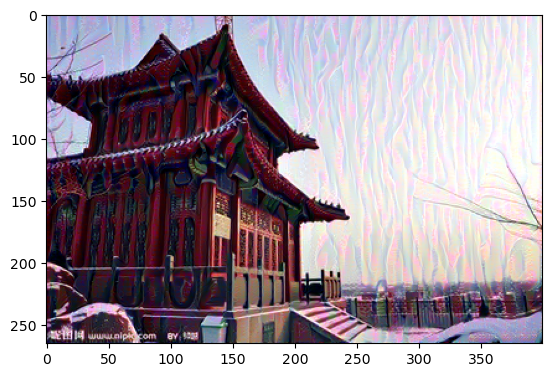

step [150/2000] , content_loss:56.8325,Style_loss:215.8585


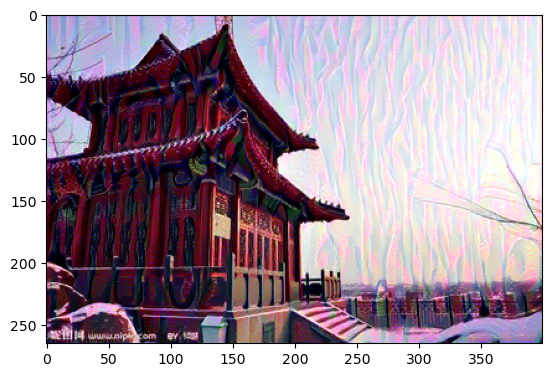

step [200/2000] , content_loss:60.1649,Style_loss:169.1805


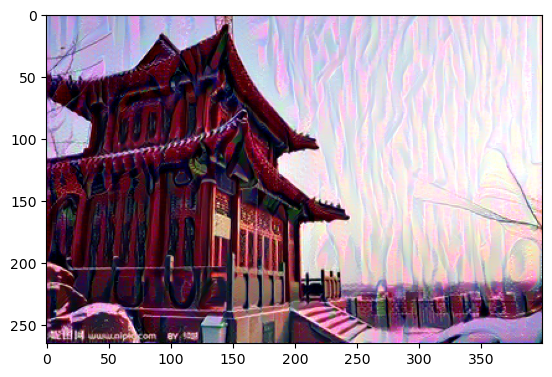

In [57]:
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)
transform=transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize(mean=(0.485,0.456,0.406)
                         ,std=(0.229,0.224,0.225))
    ,transforms.Resize(400,400)
])
content=load_image(r"G:\深度学习代码\torch实现神经网络风格迁移\dancing.jpg",transform,max_size=400)
target=content.clone().requires_grad_(True)
style=load_image(r"G:\深度学习代码\torch实现神经网络风格迁移\picasso.jpg",transform,shape=[content.size(2),content.size(3)])
optimizer=torch.optim.Adam([target],lr=0.01,betas=[0.5,0.999])
vgg=VGGNet().eval()  #保证不是更新VGGNet的参数，同时因为使用了normalize，必须要使用model.eval()
for step in range(200):
    target_features=vgg(target)
    content_features=vgg(content)
    style_features=vgg(style)
    style_loss=0
    content_loss=0
    for f1,f2,f3 in zip(target_features,content_features,style_features):
        content_loss+=torch.mean((f1-f2)**2)
        _,c,h,w=f1.size()
        f1=f1.view(c,h*w)
        f3=f3.view(c,h*w)

        f1=torch.mm(f1,f1.t())
        f3=torch.mm(f3,f3.t())
        style_loss+=torch.mean((f1-f3)**2) / (c*h*w)
        
    loss=content_loss+100*style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1) % 50 == 0:
        print("step [{}/{}] , content_loss:{:.4f},Style_loss:{:.4f}".format(step+1,2000,content_loss.item(),style_loss.item()))
        img=target.squeeze()
        img_np=np.stack([img.detach().numpy()[i]*std[i]+mean[i] for i in range(3)],axis=-1)
        img_result=img_np.clip(0,1)
        plt.imshow(img_result)
        plt.show()

In [38]:
norm=transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
denorm=transforms.Normalize((-2.12,-2.04,-1.80),(4.37,4.46,4.44))

In [51]:
print(target)
print(target.squeeze().shape)

tensor([[[[2.0948, 2.0948, 2.0948,  ..., 2.0948, 2.0948, 2.0948],
          [2.0948, 2.0948, 2.0948,  ..., 2.0948, 2.0948, 2.0948],
          [2.0948, 2.0948, 2.0948,  ..., 2.0948, 2.0948, 2.0948],
          ...,
          [2.0948, 2.0948, 2.0948,  ..., 2.0948, 2.0948, 2.0948],
          [2.0948, 2.0948, 2.0948,  ..., 2.0948, 2.0948, 2.0948],
          [2.0948, 2.0948, 2.0948,  ..., 2.0948, 2.0948, 2.0948]],

         [[2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710],
          [2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710],
          [2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710],
          ...,
          [2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710],
          [2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710],
          [2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710]],

         [[2.4831, 2.4831, 2.4831,  ..., 2.4831, 2.4831, 2.4831],
          [2.4831, 2.4831, 2.4831,  ..., 2.4831, 2.4831, 2.4831],
          [2.4831, 2.4831, 2.4831,  ..., 2

In [44]:
norm_target=norm(target)
print(norm_target)

tensor([[[[7.0296, 7.0296, 7.0296,  ..., 7.0296, 7.0296, 7.0296],
          [7.0296, 7.0296, 7.0296,  ..., 7.0296, 7.0296, 7.0296],
          [7.0296, 7.0296, 7.0296,  ..., 7.0296, 7.0296, 7.0296],
          ...,
          [7.0296, 7.0296, 7.0296,  ..., 7.0296, 7.0296, 7.0296],
          [7.0296, 7.0296, 7.0296,  ..., 7.0296, 7.0296, 7.0296],
          [7.0296, 7.0296, 7.0296,  ..., 7.0296, 7.0296, 7.0296]],

         [[8.1027, 8.1027, 8.1027,  ..., 8.1027, 8.1027, 8.1027],
          [8.1027, 8.1027, 8.1027,  ..., 8.1027, 8.1027, 8.1027],
          [8.1027, 8.1027, 8.1027,  ..., 8.1027, 8.1027, 8.1027],
          ...,
          [8.1027, 8.1027, 8.1027,  ..., 8.1027, 8.1027, 8.1027],
          [8.1027, 8.1027, 8.1027,  ..., 8.1027, 8.1027, 8.1027],
          [8.1027, 8.1027, 8.1027,  ..., 8.1027, 8.1027, 8.1027]],

         [[9.2317, 9.2317, 9.2317,  ..., 9.2317, 9.2317, 9.2317],
          [9.2317, 9.2317, 9.2317,  ..., 9.2317, 9.2317, 9.2317],
          [9.2317, 9.2317, 9.2317,  ..., 9

In [49]:
denorm_target=denorm(norm_target)
print(torch.mean(target-denorm_target)**2)

tensor(6.9316e-07, grad_fn=<PowBackward0>)


In [9]:
for i in range(5):
    print("i.shape",target_features[i].shape)

i.shape torch.Size([1, 64, 400, 400])
i.shape torch.Size([1, 128, 200, 200])
i.shape torch.Size([1, 256, 100, 100])
i.shape torch.Size([1, 512, 50, 50])
i.shape torch.Size([1, 512, 25, 25])


In [41]:
for f1,f2,f3 in zip(target_features,content_features,style_features):
    print(f1.shape)

torch.Size([1, 64, 400, 400])
torch.Size([1, 128, 200, 200])
torch.Size([1, 256, 100, 100])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 25, 25])
